## Introduction

The main focus of this notebook will be to process our data to be in the desired format for modelling. This includes splitting the data, scaling it, and transforming it using the TF-IDF Vectorizer. During the vectorization process, I will also be visualizing the data futher to expand upon the analysis done in the previous notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords 
import nltk

import re

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/movies_clean.csv')

### Splitting the Data



Here, I will make 2 different forms of my target variable. One version will be an encoded one, and another will just be 1 column.

In [3]:
X = df['Description']
y = df['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [4]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (40744,)
X_test shape: (10187,)
y_train shape: (40744,)
y_test shape: (10187,)


In [5]:
genre_dummies = pd.get_dummies(df['Genre'])

In [6]:
df.shape

(50931, 4)

In [7]:
genre_dummies.shape

(50931, 26)

In [8]:
# combine our dataframe with the target dummies.
df_dummies = pd.concat([df, genre_dummies], axis=1)

Now I will check if there are rows with multiple 1's across all columns. This means I am checking if a row has more than 1 genre.

In [9]:
x = ['Y' if x > 1 else 'N' for x in np.sum(df.values == 1, 1)]

In [10]:
count = 0
for i in x:
    if i == 'N':
        count += 1
print(count)

50931


Cool! This means that for all of my values in df_dummies, there is only 1 genre present.

Now I will create my X and y variables, and then split the data with 80% training and 20% testing.

In [11]:
df_dummies.head(1)

,Title,Genre,Description,Year,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,game show,history,horror,music,musical,mystery,news,reality tv,romance,sci fi,short,sport,talk show,thriller,war,western
0,Oscar et la dame rose (2009),drama,listening in to a conversation between his doc...,2009,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
X = df['Description']
y_enc = df_dummies.drop(columns=['Title', 'Genre', 'Description', 'Year'])

X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_enc, test_size = .2, random_state=42)

In [13]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (40744,)
X_test shape: (10187,)
y_train shape: (40744,)
y_test shape: (10187,)


Now I will filter out the stopwords and then visualize the most common words amongst these descriptions.

Wods like `the`, `to`, `it` for example will be removed.

### Visualizing Most Frequent and Most Weighted Words

Here I will create two functions: 

`plotly_most_frequent` will visualize the top 20 most frequent words in the corpus.

`plotly_most_frequentTF` will visualize the the top 20 most weighted (relevant) words in the corpus.

Later in the notebook, I will be analyzing these two categories amongst the genres individually.

In [14]:
def plotly_most_frequent(words, word_counts):
    
    """
    Function that produces plotly visualizations of the top 20 most used words in a corpus.
    
    Paremeters:
    
    words: A variable consisting of feature names of the CountVectorizer bag of words object.
    word_counts: A variable of the amount of times a word appears.
    
    """
    
    words_df = pd.DataFrame({"token": words, 
                             "count": word_counts})
    
    words_df= words_df.sort_values(by='count', ascending=False)
    
    words_df_top20 = words_df.head(20)
    
    fig = px.bar(words_df_top20, x='token', y='count', 
             title='Most Frequent Words', width=800, height=450)

    fig.update_layout(
        xaxis_title_text='Tokens', # xaxis label
        yaxis_title_text='Count of Tokens', # yaxis label
    )

    fig.show("png")

In [15]:
def plotly_most_frequentTF(words, word_weights):
    
    """
    Function that produces plotly visualizations of the top 20 most relevant words in a corpus.
    
    Paremeters:
    
    words: A variable consisting of feature names of the CountVectorizer bag of words object.
    word_weights: A variable of the weight of a word in a corpus.
    
    """
    
    
    words_df = pd.DataFrame({"token": words, 
                             "weight": word_weights})
    
    words_df= words_df.sort_values(by='weight', ascending=False)
    
    words_df_top20 = words_df.head(20)
    
    fig = px.bar(words_df_top20, x='token', y='weight', 
             title='Most Weighted Tokens', width=800, height=450)

    fig.update_layout(
        xaxis_title_text='Tokens', # xaxis label
        yaxis_title_text='Weight of Tokens', # yaxis label
    )

    fig.show("png")

I will first make a bag of words model with `CountVectorizer`, and then another with  `TF-IDF`.

For `CountVectorizer`, I am simply interested in analyzing the amount of times a token appears in a corpus.

However, for `TF-IDF`, I am interested in analyzing the most relevant words in a corpus by genre.

In [16]:
bagofwords_CV = CountVectorizer(stop_words="english")
bagofwords_CV.fit(X_train)

X_train_transformed_CV = bagofwords_CV.transform(X_train) 
X_test_transformed_CV = bagofwords_CV.transform(X_test) 

X_train_transformed_CV.shape

(40744, 101813)

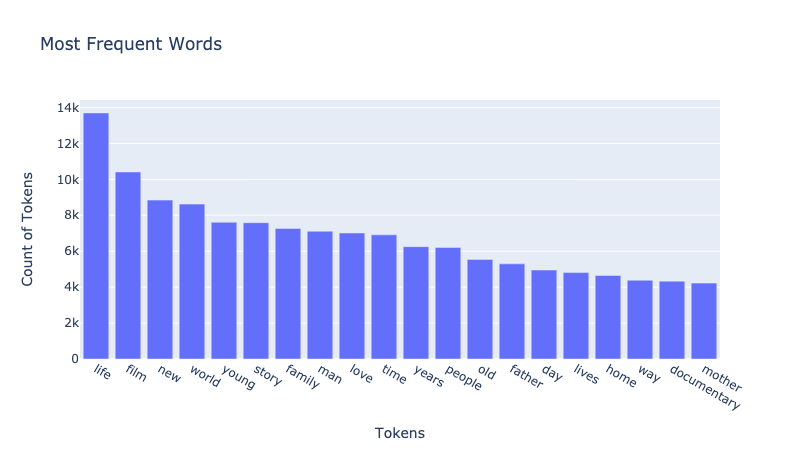

In [17]:
words = bagofwords_CV.get_feature_names()
word_counts = X_train_transformed_CV.toarray().sum(axis=0)

plotly_most_frequent(words, word_counts)

Here, the most common words in the corpus are `life`, `film`, and `new`. However, the word `life` has a significantly higher count than the rest of the words.

Now I will look into the most weighted words in the dataset using TF-IDF vectorizer.

In [18]:
tfidf = TfidfVectorizer(stop_words="english").fit(X_train)
X_train_transformed_TF = tfidf.transform(X_train)
X_test_transformed_TF = tfidf.transform(X_test)

In [19]:
X_train.shape

(40744,)

In [20]:
X_train_transformed_TF.shape

(40744, 101813)

In [21]:
my_df = pd.DataFrame(columns=tfidf.get_feature_names(), \
                     data=X_train_transformed_TF.toarray())

Now we will create a TF-IDF model and visualize the most frequent words.

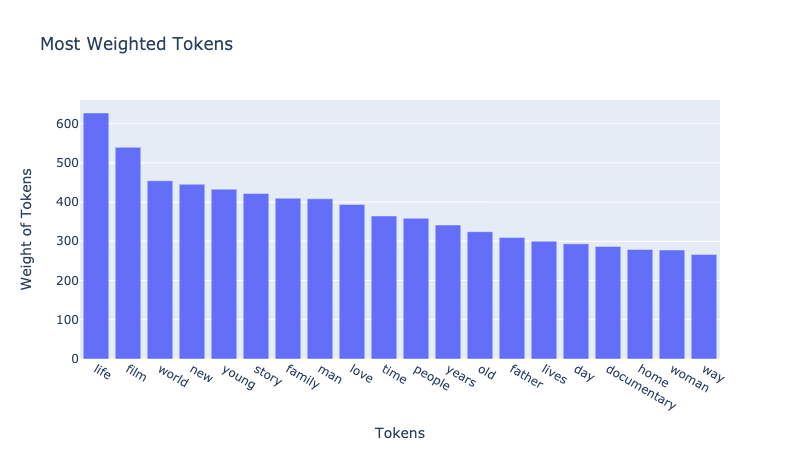

In [22]:
words = tfidf.get_feature_names()
word_weights = X_train_transformed_TF.toarray().sum(axis=0)

plotly_most_frequentTF(words, word_weights)



Here, we can see the words with the largest overall weight in the tfidf corpus. It shares similarities with the previous chart, with some words in different orders. For example, the words `world` and `new` appear in different orders in the TF-IDF chart compared to the CountVectorizer chart.

Let's look at the most common words for the top 5 genre's.

In [23]:
df['Genre'].value_counts()

documentary    12858
drama          12819
comedy          7104
short           5018
horror          1984
thriller        1338
action          1131
western         1009
reality tv       856
family           724
music            720
adventure        711
romance          637
sci fi           521
animation        461
crime            448
sport            423
talk show        390
mystery          295
fantasy          270
musical          268
biography        230
history          224
game show        193
news             181
war              118
Name: Genre, dtype: int64

I will analyze the most common words for `documentary`, `drama`, `comedy`, `short`, and `horror`. I will make a function that takes in a column, then splits the data, and then creates a TF-IDF object. A plotly chart is then returned to display the top weighted words for each genre.

In [24]:
def TF_IDF_plotly(genre):
    
    """
    Function that produces plotly visualizations of the top 20 most relevant words in a corpus.
    
    Paremeters:
    
    words: A variable consisting of feature names of the CountVectorizer bag of words object.
    word_weights: A variable of the weight of a word in a corpus.
    
    """
    
    df_genre = df[df['Genre'] == genre]
    
    y = df_genre['Genre']
    
    #Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df_genre['Description'], y,
                                                       test_size=.2,
                                                       random_state=42)
    
    # Create tfidf object for the genre specified above.
    tfidf = TfidfVectorizer(stop_words="english").fit(X_train)
    X_train_transformed_TF = tfidf.transform(X_train)
    X_test_transformed_TF = tfidf.transform(X_test)
    
    words = tfidf.get_feature_names()
    word_weights = X_train_transformed_TF.toarray().sum(axis=0)

    
    # Plotly section
    words_df = pd.DataFrame({"token": words, 
                             "weight": word_weights})
    
    words_df= words_df.sort_values(by='weight', ascending=False)
    
    words_df_top20 = words_df.head(20)
    
    genre_upper = genre.capitalize() #capitalize genre variable
    
    fig = px.bar(words_df_top20, x='token', y='weight', 
             title=(f'Most Weighted Tokens for {genre_upper}'), width=800, height=450)

    fig.update_layout(
        xaxis_title_text='Tokens', # xaxis label
        yaxis_title_text='Weight of Tokens', # yaxis label
    )

    fig.show("png")

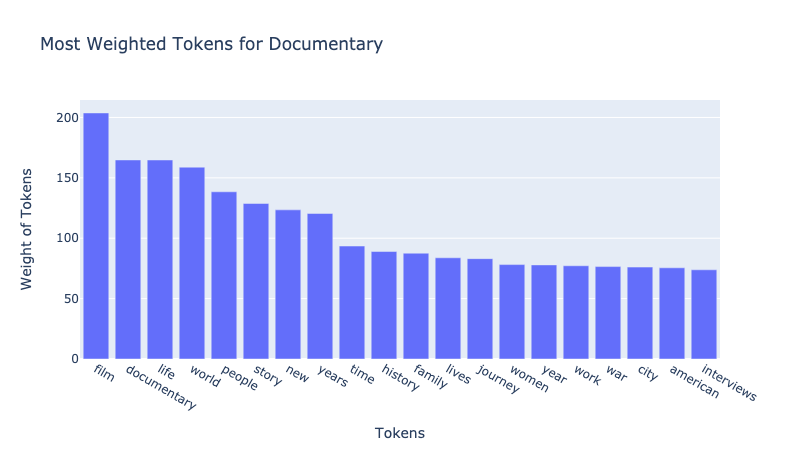

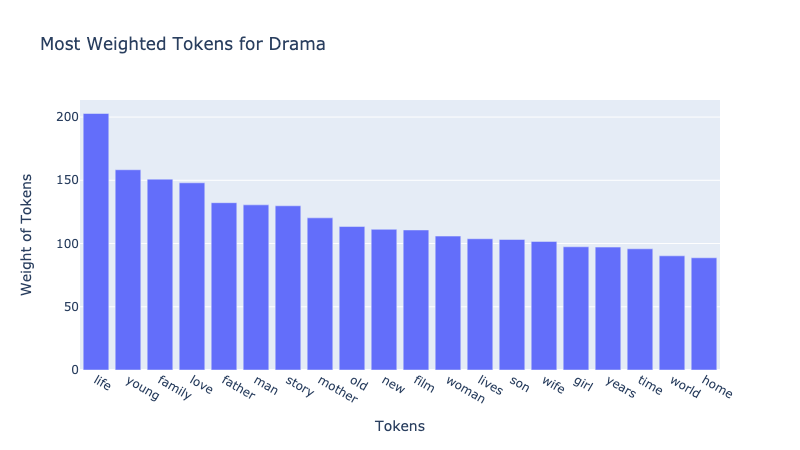

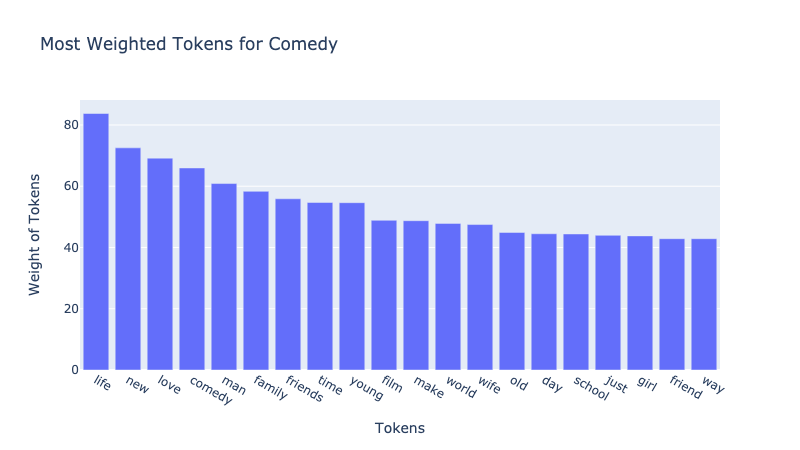

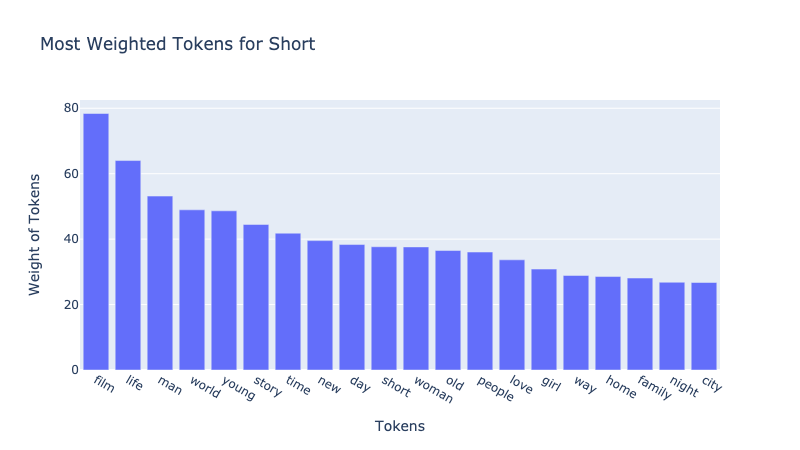

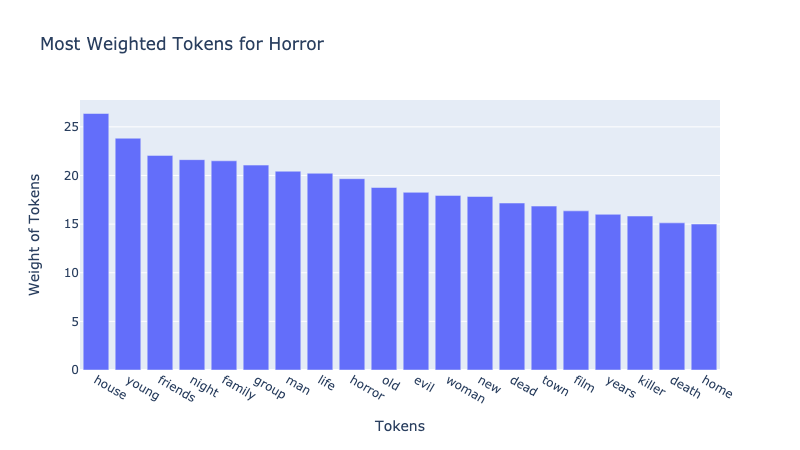

In [25]:
genres = ['documentary', 'drama', 'comedy', 'short', 'horror']

for genre in genres:
    TF_IDF_plotly(genre)

Taking a look at these graphs, the word `life` appears as the most weighted token for drama and comedy, while `film` is at number 1 for both `documentary` and `short`, while `horror` has the word `house` as number 1, which makes sense. I can't count how many time a horror movie involves a haunted house.

### Creating a TF-IDF Object

Here I will be making a TF-IDF object, and using different values of min_df to filter the amount of tokens that I want for my corpus.

In [26]:
genre_tokens = []
min_df_values = [.005, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .15, .2]

for value in min_df_values:
    
    print(f'Setting up TF-IDF with min_df={value} ', end='\r')

    tfidf = TfidfVectorizer(min_df=value)
    tfidf.fit(X_train)

    X_train_transformed = tfidf.transform(X_train)
    X_test_transformed = tfidf.transform(X_test)

    #Transfer daya into a dataframe
    X_tt_df = pd.DataFrame(data=X_train_transformed.toarray(),
                           columns=tfidf.get_feature_names())
    
    genre_tokens.append(X_tt_df.shape[1])
    


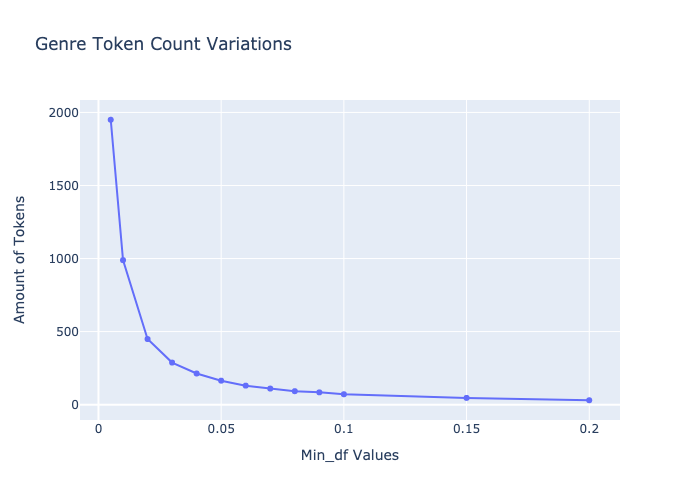

In [27]:
fig = px.line(title='Genre Token Count Variations', x=min_df_values , y=genre_tokens)

fig.update_layout(
    xaxis_title_text='Min_df Values', # xaxis label
    yaxis_title_text='Amount of Tokens', # yaxis label
)

fig.update_traces(mode='markers+lines')

fig.show("png")

Looking at this chart, it is best to set the min_df to have a value of .02.

In [28]:
tfidf = TfidfVectorizer(min_df=.02, stop_words="english")
tfidf.fit(X_train)

X_train_transformed = tfidf.transform(X_train)
X_test_transformed = tfidf.transform(X_test)



In [29]:
#Transfer data into a dataframe
X_train_t_df = pd.DataFrame(data=X_train_transformed.toarray(),
                       columns=tfidf.get_feature_names())

X_train_t_df.head(2)

,able,action,age,ago,america,american,art,artist,away,based,battle,beautiful,begins,best,better,big,black,body,boy,bring,brings,brother,business,called,car,care,career,century,chance,change,characters,child,children,city,close,college,come,comedy,comes,coming,community,company,country,couple,course,culture,dark,daughter,day,days,dead,death,decide,decides,despite,different,director,discover,discovers,documentary,does,doesn,don,drama,dream,dreams,early,end,escape,events,eventually,ex,experience,explores,face,fall,falls,family,famous,far,father,fight,film,films,finally,finds,follow,following,follows,footage,forced,free,friend,friends,future,game,gets,getting,girl,girlfriend,girls,gives,goes,going,good,government,great,group,hand,hard,having,head,heart,help,high,history,home,hope,house,human,husband,including,inside,interviews,job,john,journey,just,killed,know,known,land,late,later,law,lead,leads,learn,learns,leave,leaves,left,life,like,little,live,lives,living,local,long,look,looking,lost,love,make,makes,making,man,marriage,married,marry,meet,meets,members,men,middle,mind,modern,money,mother,movie,murder,music,mysterious,named,need,new,night,old,order,parents,party,past,people,person,personal,place,plan,play,police,political,power,present,problems,public,real,reality,really,relationship,return,returns,rich,right,road,run,save,school,search,second,secret,seen,self,series,set,sets,sex,short,shot,shows,sister,small,social,society,son,soon,south,special,star,start,starts,state,stay,stop,stories,story,struggle,student,successful,taken,takes,taking,team,tell,tells,th,things,time,times,today,told,town,tries,trip,true,truth,try,trying,turn,turns,tv,unique,use,used,using,video,village,want,wants,war,way,wife,woman,women,work,working,works,world,year,years,york,young
0,0.265717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.701467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26671,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.187281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250122,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166187,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230768,0.0,0.254061,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.252201,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.000000,0.28597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.266601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238363,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.232112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.265995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286539,0.0,0.0,0.0,0.0

In [30]:
#Transfer data into a dataframe
X_test_t_df = pd.DataFrame(data=X_test_transformed.toarray(),
                       columns=tfidf.get_feature_names())

X_test_t_df.head(2)

,able,action,age,ago,america,american,art,artist,away,based,battle,beautiful,begins,best,better,big,black,body,boy,bring,brings,brother,business,called,car,care,career,century,chance,change,characters,child,children,city,close,college,come,comedy,comes,coming,community,company,country,couple,course,culture,dark,daughter,day,days,dead,death,decide,decides,despite,different,director,discover,discovers,documentary,does,doesn,don,drama,dream,dreams,early,end,escape,events,eventually,ex,experience,explores,face,fall,falls,family,famous,far,father,fight,film,films,finally,finds,follow,following,follows,footage,forced,free,friend,friends,future,game,gets,getting,girl,girlfriend,girls,gives,goes,going,good,government,great,group,hand,hard,having,head,heart,help,high,history,home,hope,house,human,husband,including,inside,interviews,job,john,journey,just,killed,know,known,land,late,later,law,lead,leads,learn,learns,leave,leaves,left,life,like,little,live,lives,living,local,long,look,looking,lost,love,make,makes,making,man,marriage,married,marry,meet,meets,members,men,middle,mind,modern,money,mother,movie,murder,music,mysterious,named,need,new,night,old,order,parents,party,past,people,person,personal,place,plan,play,police,political,power,present,problems,public,real,reality,really,relationship,return,returns,rich,right,road,run,save,school,search,second,secret,seen,self,series,set,sets,sex,short,shot,shows,sister,small,social,society,son,soon,south,special,star,start,starts,state,stay,stop,stories,story,struggle,student,successful,taken,takes,taking,team,tell,tells,th,things,time,times,today,told,town,tries,trip,true,truth,try,trying,turn,turns,tv,unique,use,used,using,video,village,want,wants,war,way,wife,woman,women,work,working,works,world,year,years,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.338456,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275726,0.0,0.0,0.0,0.0,0.280169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.294516,0.271643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363401,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.254503,0.0,0.0,0.0,0.000000,0.0,0.332024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.346094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.223042
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.340487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.345208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302919,0.262218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331721,0.0,0.000000,0.278392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.192239,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.327723,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

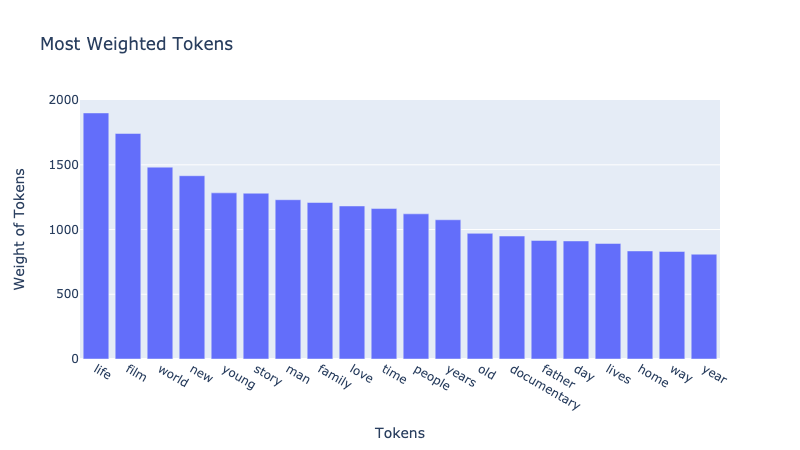

In [31]:
# Plotting the most weighted words in the entire corpus with min_df=.02

words = tfidf.get_feature_names()
word_counts = X_train_transformed.toarray().sum(axis=0)

plotly_most_frequentTF(words, word_counts)

Here are the words with the largest overall weight with `min_df=.02`

In [32]:
print('X_train:', X_train_transformed.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test_transformed.shape)
print('y_test:', y_test.shape)

X_train: (40744, 281)
y_train: (40744,)
X_test: (10187, 281)
y_test: (10187,)


In [33]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

In [34]:
y_train_df_enc = pd.DataFrame(y_train_enc)
y_test_df_enc = pd.DataFrame(y_test_enc)

Let's export these variables and start to create models from them on the next notebook.

In [37]:
X_train_t_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/X_train.csv', index = False)

y_train_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/y_train.csv', index = False)

X_test_t_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/X_test.csv', index = False)

y_test_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/y_test.csv', index = False)

y_train_df_enc.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/y_train_enc.csv', index = False)

y_test_df_enc.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/y_test_enc.csv', index = False)


### Vectorization on the Smaller Data Set

Here, I will create the vectorized data on the dataset which excludes the genres `game show`, `news`, and `war`. The purpose for this is to train my best performing models to see if the performance is improved without this information.

In [38]:
df_new = pd.read_csv('data/movies_clean_new.csv')

In [39]:
df_new.head(3)

,Title,Genre,Description,Year
0,Oscar et la dame rose (2009),drama,listening in to a conversation between his doc...,2009
1,Cupid (1997),thriller,a brother and sister with a past incestuous re...,1997
2,The Secret Sin (1915),drama,to help their unemployed father make ends meet...,1915


In [40]:
X = df_new['Description']
y = df_new['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [41]:
genre_tokens = []
min_df_values = [.005, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .15, .2]

for value in min_df_values:
    
    print(f'Setting up TF-IDF with min_df={value} ', end='\r')

    tfidf = TfidfVectorizer(min_df=value)
    tfidf.fit(X_train)

    X_train_transformed = tfidf.transform(X_train)
    X_test_transformed = tfidf.transform(X_test)

    #Transfer daya into a dataframe
    X_tt_df = pd.DataFrame(data=X_train_transformed.toarray(),
                           columns=tfidf.get_feature_names())
    
    genre_tokens.append(X_tt_df.shape[1])
    


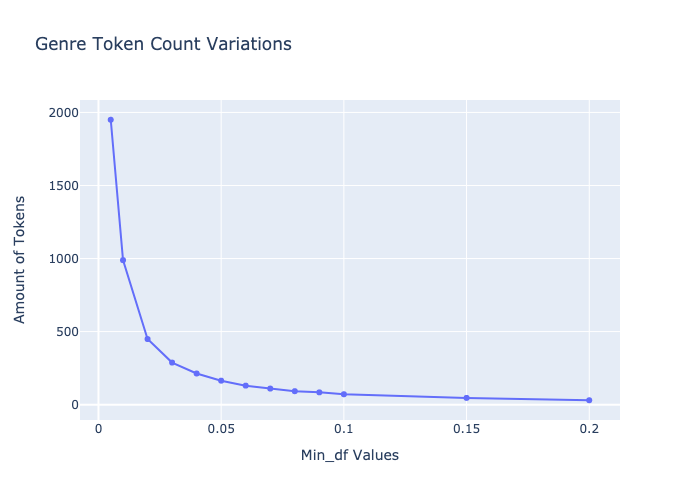

In [42]:
fig = px.line(title='Genre Token Count Variations', x=min_df_values , y=genre_tokens)

fig.update_layout(
    xaxis_title_text='Min_df Values', # xaxis label
    yaxis_title_text='Amount of Tokens', # yaxis label
)

fig.update_traces(mode='markers+lines')

fig.show("png")

Again, here it looks like `min_df=.02` is the best option.

In [43]:
tfidf = TfidfVectorizer(min_df=.02, stop_words="english")
tfidf.fit(X_train)

X_train_transformed = tfidf.transform(X_train)
X_test_transformed = tfidf.transform(X_test)

In [44]:
#Transfer data into a dataframe
X_train_t_df = pd.DataFrame(data=X_train_transformed.toarray(),
                       columns=tfidf.get_feature_names())

X_train_t_df.head(2)

,able,action,age,ago,america,american,art,artist,away,based,battle,beautiful,begins,best,better,big,black,body,boy,bring,brings,brother,business,called,car,care,career,century,chance,change,characters,child,children,city,close,college,come,comedy,comes,coming,community,company,country,couple,course,culture,dark,daughter,day,days,dead,death,decide,decides,despite,different,director,discover,discovers,documentary,does,doesn,don,drama,dream,dreams,early,end,escape,events,eventually,ex,experience,explores,face,fall,falls,family,famous,far,father,fight,film,films,finally,finds,follow,following,follows,footage,forced,free,friend,friends,future,game,gets,getting,girl,girlfriend,girls,gives,goes,going,good,government,great,group,hand,hard,having,head,heart,help,high,history,home,hope,house,human,husband,including,inside,interviews,job,john,journey,just,killed,know,known,land,late,later,law,lead,leads,learn,learns,leave,leaves,left,life,like,little,live,lives,living,local,long,look,looking,lost,love,make,makes,making,man,marriage,married,marry,meet,meets,members,men,middle,mind,modern,money,mother,movie,murder,music,mysterious,named,need,new,night,old,order,parents,party,past,people,person,personal,place,plan,play,police,political,power,present,problems,public,real,reality,really,relationship,return,returns,rich,right,road,run,save,school,search,second,secret,seen,self,series,set,sets,sex,short,shot,shows,sister,small,social,society,son,soon,south,special,star,start,starts,state,stay,stop,stories,story,struggle,student,successful,taken,takes,taking,team,tell,tells,th,things,time,times,today,told,town,tries,trip,true,truth,try,trying,turn,turns,tv,unique,use,used,using,video,village,want,wants,war,way,wife,woman,women,work,working,works,world,year,years,york,young
0,0.265717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.701467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26671,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.187281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250122,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166187,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230768,0.0,0.254061,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.252201,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,0.000000,0.28597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.266601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238363,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.232112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.265995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286539,0.0,0.0,0.0,0.0

In [45]:
#Transfer data into a dataframe
X_test_t_df = pd.DataFrame(data=X_test_transformed.toarray(),
                       columns=tfidf.get_feature_names())

X_test_t_df.head(2)

,able,action,age,ago,america,american,art,artist,away,based,battle,beautiful,begins,best,better,big,black,body,boy,bring,brings,brother,business,called,car,care,career,century,chance,change,characters,child,children,city,close,college,come,comedy,comes,coming,community,company,country,couple,course,culture,dark,daughter,day,days,dead,death,decide,decides,despite,different,director,discover,discovers,documentary,does,doesn,don,drama,dream,dreams,early,end,escape,events,eventually,ex,experience,explores,face,fall,falls,family,famous,far,father,fight,film,films,finally,finds,follow,following,follows,footage,forced,free,friend,friends,future,game,gets,getting,girl,girlfriend,girls,gives,goes,going,good,government,great,group,hand,hard,having,head,heart,help,high,history,home,hope,house,human,husband,including,inside,interviews,job,john,journey,just,killed,know,known,land,late,later,law,lead,leads,learn,learns,leave,leaves,left,life,like,little,live,lives,living,local,long,look,looking,lost,love,make,makes,making,man,marriage,married,marry,meet,meets,members,men,middle,mind,modern,money,mother,movie,murder,music,mysterious,named,need,new,night,old,order,parents,party,past,people,person,personal,place,plan,play,police,political,power,present,problems,public,real,reality,really,relationship,return,returns,rich,right,road,run,save,school,search,second,secret,seen,self,series,set,sets,sex,short,shot,shows,sister,small,social,society,son,soon,south,special,star,start,starts,state,stay,stop,stories,story,struggle,student,successful,taken,takes,taking,team,tell,tells,th,things,time,times,today,told,town,tries,trip,true,truth,try,trying,turn,turns,tv,unique,use,used,using,video,village,want,wants,war,way,wife,woman,women,work,working,works,world,year,years,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.338456,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275726,0.0,0.0,0.0,0.0,0.280169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.294516,0.271643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363401,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.254503,0.0,0.0,0.0,0.000000,0.0,0.332024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.346094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.223042
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.340487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.345208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.302919,0.262218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331721,0.0,0.000000,0.278392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.192239,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.327723,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

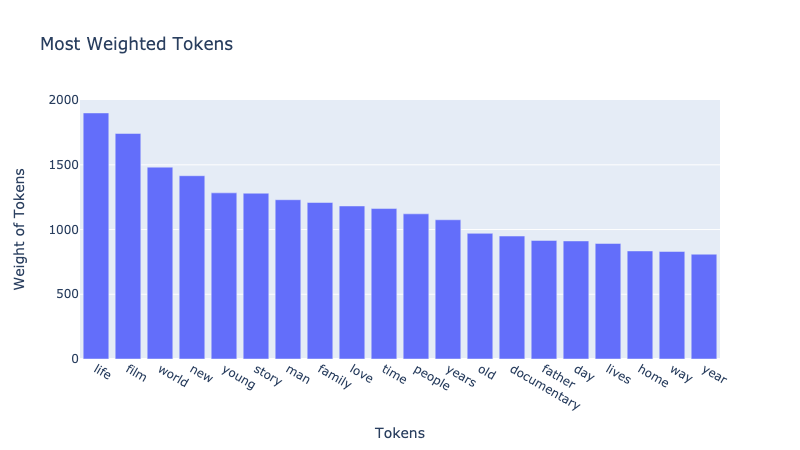

In [46]:
# Plotting the most weighted words in the entire corpus with min_df=.02

words = tfidf.get_feature_names()
word_counts = X_train_transformed.toarray().sum(axis=0)

plotly_most_frequentTF(words, word_counts)

It's very interesting to note that the resulting chart I get here is identical to the previous Most Weighted Tokens chart, even with 3 genres removed!

Now I will be exporting this data and saving it for the future modelling process.

In [ ]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

In [ ]:
X_train_t_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/data_new/X_train_new.csv', index = False)

X_test_t_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/data_new/X_test_new.csv', index = False)

y_train_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/data_new/y_train_new.csv', index = False)

y_test_df.to_csv(r'/Users/andrewalarcon/Desktop/work/Brainstation/Capstone/capstone-repo/data/data_new/y_test_new.csv', index = False)



## Conclusion

I have successfully vectorized my dataset using the TF-IDF vectorizer to gather the most weighted words in the corpus. This excludes stopwords like `the`, `it`, `where` and so on. I also removed any unnecessary puncauation, as well as lowercased all of the letters.

I also gained further insights during this vectorization process, such as discovering the top weighted words for the top 5 most appearing genres in the dataset.

After the vectorization proccess, I exported the data into csv files so that they could be used for the modelling process, which will be done in the next notebook.
